# Image Captioning using the Show and Tell architecture from this paper: https://arxiv.org/abs/1411.4555

In [44]:
from keras.preprocessing import sequence,image
from keras.applications.inception_v3 import InceptionV3
from keras.models import Sequential, Model, load_model
from keras.layers import LSTM, Embedding,BatchNormalization
from keras.layers import Dropout, TimeDistributed, Dense,Concatenate, RepeatVector, Activation, Input, add
from keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import Bidirectional
from keras import Input
from tqdm import tqdm_notebook as tqdm
from keras import backend 
from PIL import Image
import numpy as np
import pandas as pd
import pickle
from IPython.display import display
%matplotlib inline
from matplotlib.pyplot import imshow
from nltk.translate.bleu_score import sentence_bleu
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.utils.vis_utils import plot_model

Packages used: keras, nltk, tqdm, numpy, pandas, pickle, matplotlib, pillow

## Change paths for data here

We use the flickr 8k dataset for our image captioning task. The flickr8k dataset contains 6000 images in the training set and 1000 images in the testing set. Each image has upto 5 different captions. 

The file 'Flickr_8k.trainImages.txt' contains the image ids for the training images and similarly 'Flickr_8k.testImages.txt' for testing images. 'Flickr8k.token.txt' contains the captions for all images. 

'trainImages.txt' and 'testImages.txt' are preprocessed files using 'preprocessing_flickr.py' file. The folder 'Flickr8k_Dataset/' contains the path for all the images.

In [3]:
token_file = "/home/nishimehta15/NIC/flickr/Flickr8k_text/Flickr8k.token.txt"
train_cap_file = "/home/nishimehta15/NIC/flickr/Flickr8k_text/Flickr_8k.trainImages.txt"
test_cap_file = "/home/nishimehta15/NIC/flickr/Flickr8k_text/Flickr_8k.testImages.txt"
images_path= '/home/nishimehta15/NIC/flickr/Flickr8k_Dataset/'
preprocessed_train_file = '/home/nishimehta15/NIC/flickr/trainImages.txt'
preprocessed_test_file = '/home/nishimehta15/NIC/flickr/testImages.txt'

In [4]:
train_imgs_id = open(train_cap_file).read().split('\n')[:-1]
test_imgs_id = open(test_cap_file).read().split('\n')[:-1]

## Data Preprocessing
In order to pass the data throught the inception net or any other network we need to preprocess it. We first scale the image to 299x299 which is required for the inception net input and then we scale the pixel values between -1 to 1.

In [5]:
def scale_pixels(x):
    x /= 127.5
    x -= 1
    return x
def preprocess(image_path):
    img = image.load_img(image_path, target_size=(299, 299))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = scale_pixels(x)
    return x

## Inception V3
We use the inception net V3 to encode the images and get the bottleneck features for caption generation. Keras provides a pretrained network on the imagenet dataset. We leverage this pretrained model for our model.

In [6]:
inception_model = InceptionV3(weights='imagenet')
new_input = inception_model.input
encoded = inception_model.layers[-2].output
inception_model_feat = Model(new_input, encoded)

### Image encoding
We encode the images using the inception net and cache it to a pickle file for faster processing.

In [10]:
train_set = {}
for i in tqdm(train_imgs_id):
    path = images_path + str(i)
    img = preprocess(path)
    temp = inception_model_feat.predict(img)
    temp = np.reshape(temp, temp.shape[1])
    train_set[i] = temp

100%|██████████| 6000/6000 [02:36<00:00, 38.44it/s]


In [ ]:
with open("inceptionv3_encoded_train.p", "wb") as encoded_pickle: 
    pickle.dump(train_set, encoded_pickle)

In [7]:
encoding_train = pickle.load(open('inceptionv3_encoded_train.p', 'rb'))

In [8]:
trainData = pd.read_csv(preprocessed_train_file, delimiter='\t')
captions = []
image_names = []
for row in trainData.iterrows():
    captions.append(row[1][1])
    image_names.append(row[1][0])

## Sequencing
We use a preprocessed vocabulary which basically contains all the unique words present in the caption dataset. Each word is given an index. 

Using this vocabulary, we generate two maps:

1. Word to Index

2. Index to Word

We will use these maps moving forward.

We also maintain a variable for the value of the maximum length caption.

In [9]:
vocab = pickle.load(open('vocab.p', 'rb'))
vocab_size = len(vocab)
vocab_size

8256

In [10]:
word_idx = {val:index for index, val in enumerate(vocab)}
idx_word = {index:val for index, val in enumerate(vocab)}
caption_length = [len(caption.split()) for caption in captions]
max_length = max(caption_length)
max_length

40

In [11]:
data_size = 0
for caption in captions:
    data_size+=len(caption.split())-1

## Model Architecture
This is where we build our model. Two inputs are used. The first input is the partial caption and the second input is the encoded latent features of the image. The output is a probability distribution of all the words in the vocab. This basically represents the next word in the caption. We choose the one with the highest probability.

In [12]:
EMBEDDING_DIM = 300 

image_inputs = Input(shape=(2048,))
image_model = Dropout(0.5)(image_inputs)
image_model_D = Dense(256, activation='relu')(image_model)

lang_inputs = Input(shape=(max_length,))
lang_model = Embedding(vocab_size, EMBEDDING_DIM, mask_zero=True)(lang_inputs)
lang_model_d = Dropout(0.5)(lang_model)
lang_model_s = LSTM(256)(lang_model_d)

decoder = add([image_model_D, lang_model_s])
decoder_d = Dense(256, activation='relu')(decoder)

outputs = Dense(vocab_size, activation='softmax')(decoder_d)
final_model = Model(inputs=[image_inputs, lang_inputs], outputs=outputs)

final_model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



In [37]:
final_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 40)           0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 40, 300)      2476800     input_4[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 2048)         0           input_3[0][0]                    
____________________________________________________________________________________________

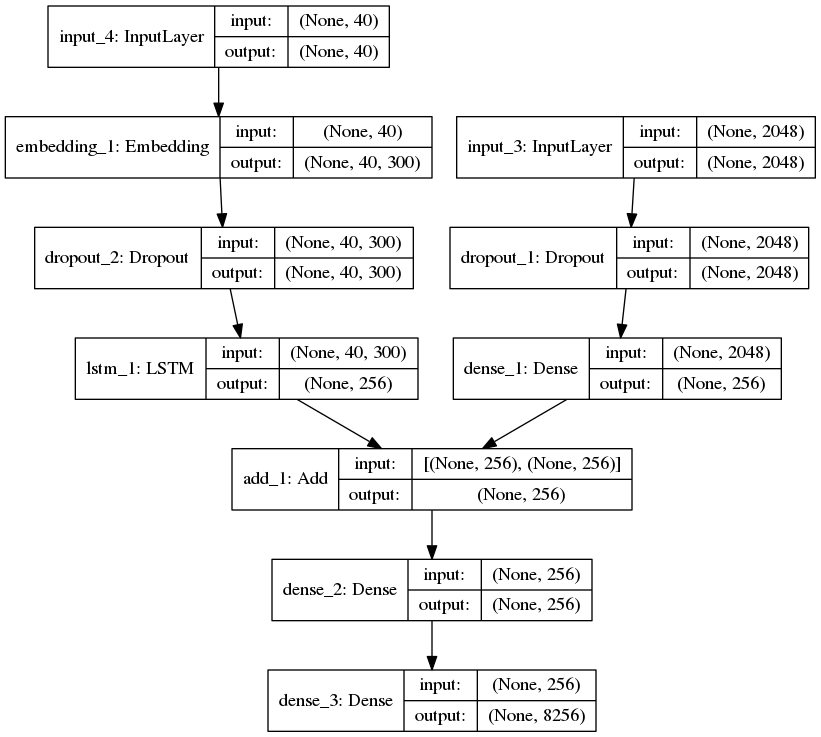

In [38]:
plot_model(final_model, show_shapes=True, show_layer_names=True)

## Data generator

This is our data generator. This will yield data of a specific batch size for the model. 

There are two inputs to the model: 1. partial captions and 2. encoded images.

The target value for the model is given by a map of all vocab words and indicates which one is present.

In [13]:
def data_process(batch_size):
    partial_captions = []
    next_words = []
    images= []
    total_count = 0
    while 1:
        
        for image_counter, caption in enumerate(captions):
            current_image = encoding_train[image_names[image_counter]]
    
            for i in range(len(caption.split())-1):
                total_count+=1
                partial = [word_idx[txt] for txt in caption.split()[:i+1]]
                partial_captions.append(partial)
                next = np.zeros(vocab_size)
                next[word_idx[caption.split()[i+1]]] = 1
                next_words.append(next)
                images.append(current_image)

                if total_count>=batch_size:
                    next_words = np.asarray(next_words)
                    images= np.asarray(images)
                    partial_captions = sequence.pad_sequences(partial_captions, maxlen=max_length, padding='post')
                    total_count = 0
                
                    yield [[images, partial_captions], next_words]
                    partial_captions = []
                    next_words = []
                    images= []


## Training

In [16]:
epoch = 50
batch_size = 512
generator = data_process(batch_size=batch_size)
final_model.fit_generator(generator, steps_per_epoch=no_samples/batch_size, epochs=epoch, verbose=1, callbacks=None)

final_model.save('showandtell_inception.h5')


Epoch 1/50
749/748 [==============================] - 117s 156ms/step - loss: 3.9787 - acc: 0.3125
Epoch 2/50
749/748 [==============================] - 113s 150ms/step - loss: 3.0933 - acc: 0.3918
Epoch 3/50
749/748 [==============================] - 113s 151ms/step - loss: 2.8010 - acc: 0.4156
Epoch 4/50
749/748 [==============================] - 113s 151ms/step - loss: 2.6097 - acc: 0.4309
Epoch 5/50
749/748 [==============================] - 113s 151ms/step - loss: 2.4652 - acc: 0.4435
Epoch 6/50
749/748 [==============================] - 113s 151ms/step - loss: 2.3492 - acc: 0.4561
Epoch 7/50
749/748 [==============================] - 113s 151ms/step - loss: 2.2551 - acc: 0.4673
Epoch 8/50
749/748 [==============================] - 113s 151ms/step - loss: 2.1774 - acc: 0.4785
Epoch 9/50
749/748 [==============================] - 114s 152ms/step - loss: 2.1079 - acc: 0.4876
Epoch 10/50
749/748 [==============================] - 113s 151ms/step - loss: 2.0532 - acc: 0.4959
Epoch 11

In [40]:
# Using the pretrained saved model
final_model = load_model('showandtell_inception.h5')

## Encoding the test images

In [22]:
test_set = {}
for i in tqdm(test_imgs_id):
    path = images_path + str(i)
    img = preprocess(path)
    temp = inception_model_feat.predict(img)
    temp = np.reshape(temp, temp.shape[1])
    test_set[i] = temp

100%|██████████| 1000/1000 [01:17<00:00, 12.94it/s]


In [23]:
with open("inceptionv3_encoded_test.p", "wb") as encoded_pickle: 
    pickle.dump(test_set, encoded_pickle)

In [18]:
encoding_test = pickle.load(open('inceptionv3_encoded_test.p', 'rb'))

## Evaluation
In order to predict the caption we first give the start token and then keep predicting the next word until we dont get end token or reach the maximum caption length

In [19]:
def predict_captions(image_file,model=final_model,encoding_test=encoding_test):
    start_word = ["<start>"]
    while 1:
        now_caps = [word_idx[i] for i in start_word]
        now_caps = sequence.pad_sequences([now_caps], maxlen=max_length, padding='post')
        e = encoding_test[image_file]
        preds = model.predict([np.array([e]), np.array(now_caps)])
        word_pred = idx_word[np.argmax(preds[0])]
        start_word.append(word_pred)
        
        if word_pred == "<end>" or len(start_word) > max_length: 
            break
            
    return ' '.join(start_word[1:-1])


Predicted Caption: A dog shakes its head while standing in a field .


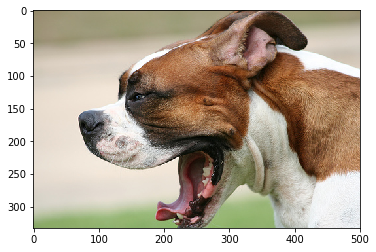

In [20]:
image_file ="256085101_2c2617c5d0.jpg"
test_image = images_path+ image_file
im = Image.open(test_image)
print ('Predicted Caption:', predict_captions(image_file))
imshow(np.array(im))

Predicted Caption: A man climbs a rock .


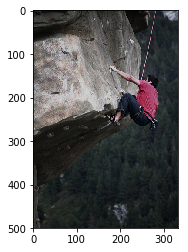

In [28]:
image_file ="997722733_0cb5439472.jpg"
test_image = images_path + image_file
im = Image.open(test_image)
print ('Predicted Caption:', predict_captions(image_file))
print('Actual Caption: ',)
imshow(np.array(im))

## Bleu Score

We calculate the bleu-1 score for all the predicted captions in the test set.

In [22]:
imgid_with_cap = open(preprocessed_test_file).read().split("\n")
bleu_scores = []
for i in tqdm(range(len(imgid_with_cap)-1)):
    idop = imgid_with_cap[i].split("\t")
    image_id = idop[0]
    bleu_score = sentence_bleu(predict_captions(image_file),idop[1],weights=(1, 0, 0, 0))
    bleu_scores.append(bleu_score)

In [23]:
print('Average Bleu-1 Score: ',np.mean(bleu_scores))
print('Maximum Bleu-1 Score: ',np.max(bleu_scores))
print('Minimum Bleu-1 Score: ',np.min(bleu_scores))

Average Bleu-1 Score:  0.2221657966786087
Maximum Bleu-1 Score:  0.48148148148148145
Minimum Bleu-1 Score:  0.08982035928143714


## VGG 16

We repeat the same process. But this time we use the VGG 16 model instead of the inception net.

In [24]:
def preprocess_vgg(image_path):
    img = image.load_img(image_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = scale_pixels(x)
    return x

In [25]:
model = VGG16(weights='imagenet')
new_input = model.input
new_output = model.layers[-1].output
vgg_model = Model(new_input, new_output)

In [ ]:
train_set = {}
for i in tqdm(train_imgs_id):
    path = images_path + str(i)
    img = preprocess_vgg(path)
    temp = vgg_model.predict(img)
    temp = np.reshape(temp, temp.shape[1])
    train_set[i] = temp

In [46]:
with open("vgg16_encoded_train.p", "wb") as encoded_pickle: 
    pickle.dump(train_set, encoded_pickle)

In [26]:
encoding_train = pickle.load(open('vgg16_encoded_train.p', 'rb'))

In [27]:
EMBEDDING_DIM = 300 

image_inputs = Input(shape=(1000,))
image_model = Dropout(0.5)(image_inputs)
image_model_D = Dense(256, activation='relu')(image_model)

lang_inputs = Input(shape=(max_length,))
lang_model = Embedding(vocab_size, EMBEDDING_DIM, mask_zero=True)(lang_inputs)
lang_model_d = Dropout(0.5)(lang_model)
lang_model_s = LSTM(256)(lang_model_d)

decoder = add([image_model_D, lang_model_s])
decoder_d = Dense(256, activation='relu')(decoder)

outputs = Dense(vocab_size, activation='softmax')(decoder_d)
final_model_vgg = Model(inputs=[image_inputs, lang_inputs], outputs=outputs)

final_model_vgg.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

## Training

In [55]:
epoch = 20
batch_size = 512
generator = data_process(batch_size=batch_size)
final_model_vgg.fit_generator(generator, steps_per_epoch=data_size/batch_size, epochs=epoch, verbose=1, callbacks=None)

final_model_vgg.save('showandtell_vgg.h5')


Epoch 1/20
749/748 [==============================] - 130s 173ms/step - loss: 4.3964 - acc: 0.2738
Epoch 2/20
749/748 [==============================] - 126s 168ms/step - loss: 3.5602 - acc: 0.3497
Epoch 3/20
749/748 [==============================] - 124s 166ms/step - loss: 3.2992 - acc: 0.3698
Epoch 4/20
749/748 [==============================] - 126s 168ms/step - loss: 3.1237 - acc: 0.3833
Epoch 5/20
749/748 [==============================] - 126s 168ms/step - loss: 2.9883 - acc: 0.3934
Epoch 6/20
749/748 [==============================] - 127s 169ms/step - loss: 2.8770 - acc: 0.4020
Epoch 7/20
749/748 [==============================] - 126s 168ms/step - loss: 2.7811 - acc: 0.4096
Epoch 8/20
749/748 [==============================] - 126s 168ms/step - loss: 2.6980 - acc: 0.4163
Epoch 9/20
749/748 [==============================] - 126s 169ms/step - loss: 2.6237 - acc: 0.4221
Epoch 10/20
749/748 [==============================] - 127s 169ms/step - loss: 2.5567 - acc: 0.4288
Epoch 11/

In [32]:
final_model_vgg = load_model('showandtell_vgg.h5')

In [ ]:
test_set = {}
for i in tqdm(test_imgs_id):
    path = images_path + str(i)
    img = preprocess_vgg(path)
    temp = vgg_model.predict(img)
    temp = np.reshape(temp, temp.shape[1])
    test_set[i] = temp
with open("vgg_encoded_test.p", "wb") as encoded_pickle: 
    pickle.dump(test_set, encoded_pickle)
    

In [28]:
encoding_test_vgg = pickle.load(open('vgg_encoded_test.p', 'rb'))

## Evaluation

Predicted Caption: A dog with a red collar is walked .


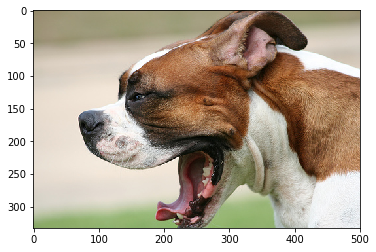

In [33]:
image_file ="256085101_2c2617c5d0.jpg"
test_image = images_path+ image_file
im = Image.open(test_image)
print ('Predicted Caption:', predict_captions(image_file,final_model_vgg,encoding_test_vgg))
imshow(np.array(im))

Predicted Caption: A man in a red shirt is abseiling down a snowy mountain .


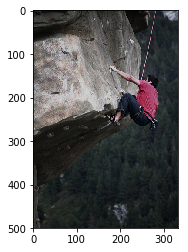

In [34]:
image_file ="997722733_0cb5439472.jpg"
test_image = images_path + image_file
im = Image.open(test_image)
print ('Predicted Caption:', predict_captions(image_file,final_model_vgg,encoding_test_vgg))
imshow(np.array(im))

In [39]:
imgid_with_cap = open(preprocessed_test_file).read().split("\n")
bleu_scores = []
for i in tqdm(range(len(imgid_with_cap)-1)):
    idop = imgid_with_cap[i].split("\t")
    image_id = idop[0]
    bleu_score = sentence_bleu(predict_captions(image_file,final_model_vgg,encoding_test_vgg),idop[1],weights=(1, 0, 0, 0))
    bleu_scores.append(bleu_score)

/usr/local/lib/python3.5/dist-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.5/dist-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.5/dist-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg

In [41]:
print('Average Bleu-1 Score: ',np.mean(bleu_scores))
print('Maximum Bleu-1 Score: ',np.max(bleu_scores))
print('Minimum Bleu-1 Score: ',np.min(bleu_scores))

Average Bleu-1 Score:  0.2588693396308402
Maximum Bleu-1 Score:  0.56
Minimum Bleu-1 Score:  0.10559006211180123


## VGG 19
We repeat the same process. But this time we use the VGG 19 model.

In [45]:
def preprocess_vgg19(image_path):
    img = image.load_img(image_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = scale_pixels(x)
    return x

In [47]:
model = VGG19(weights='imagenet')
new_input = model.input
new_output = model.layers[-1].output
vgg19_model = Model(new_input, new_output)

In [48]:
train_set = {}
for i in tqdm(train_imgs_id):
    path = images_path + str(i)
    img = preprocess_vgg(path)
    temp = vgg19_model.predict(img)
    temp = np.reshape(temp, temp.shape[1])
    train_set[i] = temp

In [49]:
with open("vgg19_encoded_train.p", "wb") as encoded_pickle: 
    pickle.dump(train_set, encoded_pickle)

In [50]:
encoding_train = pickle.load(open('vgg19_encoded_train.p', 'rb'))

In [51]:
final_model_vgg19 = Model(inputs=[image_inputs, lang_inputs], outputs=outputs)
final_model_vgg19.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

## Training

In [52]:
epoch = 20
batch_size = 512
generator = data_process(batch_size=batch_size)
final_model_vgg19.fit_generator(generator, steps_per_epoch=data_size/batch_size, epochs=epoch, verbose=1, callbacks=None)

final_model_vgg19.save('showandtell_vgg19.h5')


Epoch 1/20
749/748 [==============================] - 117s 156ms/step - loss: 4.3962 - acc: 0.2751
Epoch 2/20
749/748 [==============================] - 114s 152ms/step - loss: 3.5653 - acc: 0.3481
Epoch 3/20
749/748 [==============================] - 114s 152ms/step - loss: 3.2961 - acc: 0.3696
Epoch 4/20
749/748 [==============================] - 120s 160ms/step - loss: 3.1158 - acc: 0.3830
Epoch 5/20
749/748 [==============================] - 124s 166ms/step - loss: 2.9857 - acc: 0.3928
Epoch 6/20
749/748 [==============================] - 123s 164ms/step - loss: 2.8806 - acc: 0.4020
Epoch 7/20
749/748 [==============================] - 114s 153ms/step - loss: 2.7887 - acc: 0.4086
Epoch 8/20
749/748 [==============================] - 114s 152ms/step - loss: 2.7081 - acc: 0.4146
Epoch 9/20
749/748 [==============================] - 114s 152ms/step - loss: 2.6362 - acc: 0.4205
Epoch 10/20
749/748 [==============================] - 114s 152ms/step - loss: 2.5720 - acc: 0.4262
Epoch 11/

In [53]:
final_model_vgg19 = load_model('showandtell_vgg19.h5')

In [55]:
test_set = {}
for i in tqdm(test_imgs_id):
    path = images_path + str(i)
    img = preprocess_vgg(path)
    temp = vgg19_model.predict(img)
    temp = np.reshape(temp, temp.shape[1])
    test_set[i] = temp
with open("vgg19_encoded_test.p", "wb") as encoded_pickle: 
    pickle.dump(test_set, encoded_pickle)
    

In [56]:
encoding_test_vgg19 = pickle.load(open('vgg19_encoded_test.p', 'rb'))

## Evaluation

Predicted Caption: A brown dog is running on the grass .


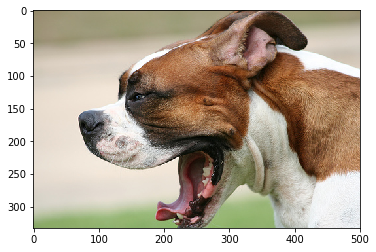

In [57]:
image_file ="256085101_2c2617c5d0.jpg"
test_image = images_path+ image_file
im = Image.open(test_image)
print ('Predicted Caption:', predict_captions(image_file,final_model_vgg19,encoding_test_vgg19))
imshow(np.array(im))

Predicted Caption: A man in a red shirt is standing on a rock overlooking the ocean .


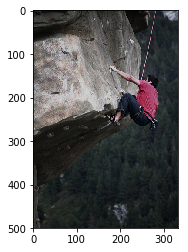

In [58]:
image_file ="997722733_0cb5439472.jpg"
test_image = images_path + image_file
im = Image.open(test_image)
print ('Predicted Caption:', predict_captions(image_file,final_model_vgg19,encoding_test_vgg19))
imshow(np.array(im))

In [59]:
imgid_with_cap = open(preprocessed_test_file).read().split("\n")
bleu_scores = []
for i in tqdm(range(len(imgid_with_cap)-1)):
    idop = imgid_with_cap[i].split("\t")
    image_id = idop[0]
    bleu_score = sentence_bleu(predict_captions(image_file,final_model_vgg19,encoding_test_vgg19),idop[1],weights=(1, 0, 0, 0))
    bleu_scores.append(bleu_score)

/usr/local/lib/python3.5/dist-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.5/dist-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.5/dist-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg

In [60]:
print('Average Bleu-1 Score: ',np.mean(bleu_scores))
print('Maximum Bleu-1 Score: ',np.max(bleu_scores))
print('Minimum Bleu-1 Score: ',np.min(bleu_scores))

Average Bleu-1 Score:  0.24125803532402634
Maximum Bleu-1 Score:  0.5185185185185185
Minimum Bleu-1 Score:  0.09580838323353294
